This is a Jupyter notebook introducing some basic elements of the Qiskit framework. Here we will implement some of the concepts you have learned so far.

First we need to import some packages: 

In [77]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister # necessary for designing (QuantumCircuit, assemble)
from qiskit import IBMQ, Aer, transpile                               # Needed for compiling circuits
from qiskit_aer import AerSimulator               # Randomness generator for simulating random outcomes of quantum experiments
from qiskit.visualization import plot_histogram, plot_bloch_multivector, array_to_latex # Also visualisation never hurts
from qiskit.extensions import Initialize
from qiskit.result import marginal_counts
from qiskit.quantum_info import random_statevector
from math import sqrt, pi

As a first example, we build a quantum circuit on one qubit which prepares the $|1\rangle$ state and measures in the computational 
basis. By default all registers of quantum circuits are initialised in the state $|0\rangle$

In [78]:
qc = QuantumCircuit(1,1)  # Create a quantum circuit with one qubit and a classical register for measurement outputs
initial_state = [0,1]   # Defines initial_state as |1>; in general [a,b] for a|0>+b|1>
qc.initialize(initial_state, 0) # Apply initialisation operation to the first qubit
qc.measure([0],[0])    #Measures the first qubit and puts the result in the first classical register

In order to compile and run the circuit need to do the following:

In [79]:
simulator = AerSimulator()                  #loads the simulator
qc_compiled = transpile(qc, simulator)      #compiles the circuit
experiment = simulator.run(qc_compiled, shots=100) # runs the experiment for any desired number of rounds (here 100)

We can now access the results of the experiment:

In [80]:
result=experiment.result()
counts = result.get_counts(qc_compiled)
print("\nTotal count for 0 and 1 are:", counts)


Total count for 0 and 1 are: {'1': 100}


Or, if you prefer a visual representation:

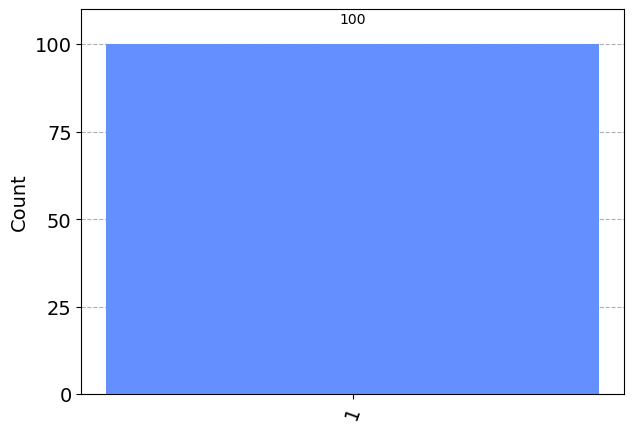

In [81]:
plot_histogram(counts)

Either way, the outcome is always '1', which comes to no surprise. Before we move on to examples with more parties, let us briefly check what happens if we add a Hadamard gate to the circuit.

In [82]:
qc = QuantumCircuit(1)           # Create a circuit with one qubit           
qc.h(0)                          # Here we apply the Hadamard gate
qc.measure_all()                 # and then measure our final state         

We can also visualize our circuit as follows

In [83]:
qc.draw()

┌───┐ ░ ┌─┐
     q: ┤ H ├─░─┤M├
        └───┘ ░ └╥┘
meas: 1/═════════╩═
                 0

if this visual representation is too bland, we can make it look a tad bit nicer by using a different renderer.

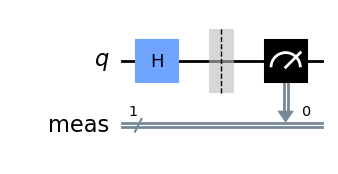

In [84]:
qc.draw(output='mpl')

now let us run the experiment again and see what outcomes we get


Total count for 0 and 1 are: {'0': 44, '1': 56}


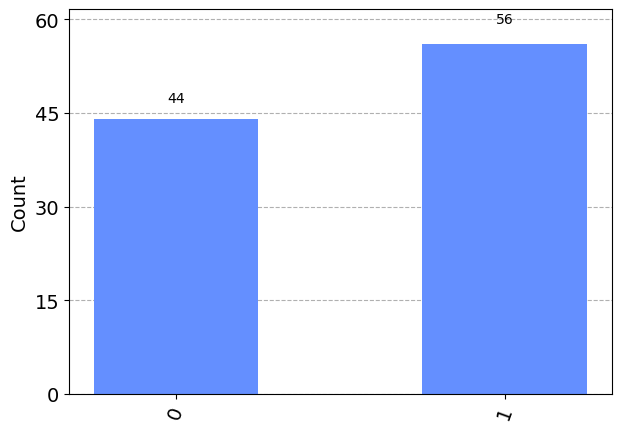

In [85]:
qc_compiled = transpile(qc, simulator)      
experiment = simulator.run(qc_compiled, shots=100) 
result=experiment.result()
counts = result.get_counts(qc_compiled)

print("\nTotal count for 0 and 1 are:", counts)
plot_histogram(counts)

we thus see that both the outcomes 0 and 1 appear roughly equally.

**Exercise:** Modify the example above to perform a consistency check that the Pauli X and Z gates are related by the Hadamard gate $H$ via $X=HZH$.

Let us now move on to a slightly more complicated example, where we prepare a Bell state.

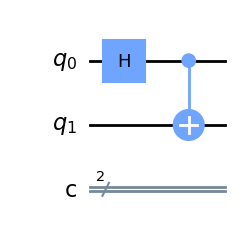

In [86]:
qc = QuantumCircuit(2,2) 
qc.h(0)
qc.cnot(0,1) # Applies a Pauli X (NOT in computational basis) to register 1, conditioned on register 0.
qc.r

qc.draw(output='mpl')

In [87]:
v=qc.measure([0,1],[0,1])
simulator = AerSimulator()                 
qc_compiled = transpile(qc, simulator)      
experiment = simulator.run(qc_compiled, shots=100) 
result=experiment.result()
counts = result.get_counts(qc_compiled)
print("\nTotal counts", counts)


Total counts {'11': 47, '00': 53}


**Exercise 1:** Modify the circuit above to create a GHZ state on three or more parties. 

**Exercise 2:** Also familiarise yourself with the effects of other built-in gates, such as Pauli X,Y,Z, the parametrised phase gate P, or multi-qubit operations (e.g. CZ, Toffoli). Design quantum circuits which make the effect of these gates visible in the measurement statistics. (A non-example: Initialising a qubit in '0' or '1', applying the Z gate and measuring in the computational basis would lead you to believe that nothing happened at all.)

With the above ingredients at hand, we can now implement the teleportation protocol! For this protocol we need three qubits, two of which will be entangled among Alice and Bob, we will also need a classical register for Alice to store the values of her outcomes and communicate them to Bob. We start as follows:

In [115]:
qr = QuantumRegister(3, name="q")    # Protocol uses 3 qubits
crz = ClassicalRegister(1, name="crz") # and 2 classical bits
crx = ClassicalRegister(1, name="crx") # in 2 different registers
teleportation_circuit = QuantumCircuit(qr, crz, crx)

We now need to create a Bell state, since we do this operation often it is useful to wrap the process into a function as follows:

In [89]:
def create_bell_pair(qc, a, b):
    """Creates a bell pair in qc using qubits a & b"""
    qc.h(a) # Put qubit a into state |+>
    qc.cx(a,b) # CNOT with a as control and b as target

We start by creating a Bell pair between Alice and Bob

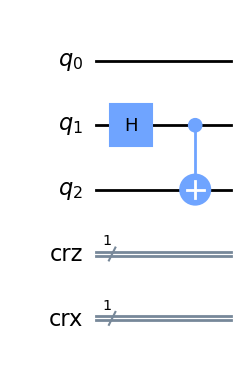

In [116]:
create_bell_pair(teleportation_circuit, 1, 2)
teleportation_circuit.draw('mpl')

Now Alice needs to perform a Bell-basis measurement in her lab. This can be achieved by inverting the preperation of the Bell state, and then performing the ordinary computational basis measurement.

In [92]:
def alice_gates(qc, psi, a):  
    qc.cx(psi, a)
    qc.h(psi)

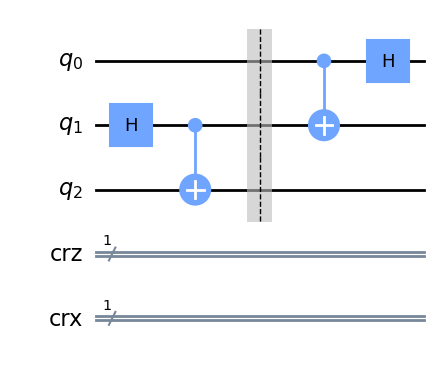

In [93]:
teleportation_circuit.barrier() # Use barrier to separate steps
alice_gates(teleportation_circuit, 0, 1)
teleportation_circuit.draw('mpl')

Alice now measures here two qubits and sends the outcomes to Bob. He already having the second half of the qubit then applies the following gates depending on the state of the classical bits:

$00$ Do nothing

$01$ Apply $X$ gate

$10$ Apply $Z$ gate

$11$ Apply $ZX$ gate

(We notice that this transfer of information is purely classical and it is due to this step teleportation is not instantaneous since classical communication is bounded by the speed of light.)

In [117]:
def measure_and_send(qc, a, b):
    #Measures qubits a & b and 'sends' the results to Bob
    qc.barrier()
    qc.measure(a,0)
    qc.measure(b,1)
    
def bob_gates(qc, qubit, crz, crx):
    # Here we use c_if to control our gates with a classical bit instead of a qubit
    qc.x(qubit).c_if(crx, 1) # Apply gates if the registers 
    qc.z(qubit).c_if(crz, 1) # are in the state '1'

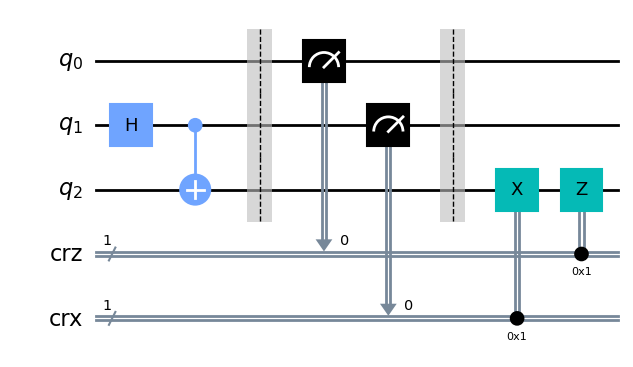

In [118]:
measure_and_send(teleportation_circuit, 0 ,1)
teleportation_circuit.barrier()
bob_gates(teleportation_circuit, 2, crz, crx)
teleportation_circuit.draw('mpl')

Now let us test our circuit if it works properly, we will initialise a random state and then try to simulate the above teleportation circuit.

<IPython.core.display.Latex object>

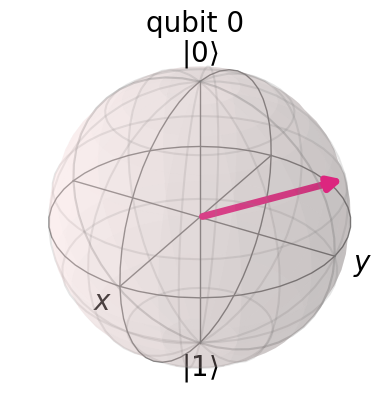

In [136]:
# Create random 1-qubit state
psi = random_statevector(2)

# Display it nicely
display(array_to_latex(psi, prefix="|\\psi\\rangle ="))
# Show it on a Bloch sphere
plot_bloch_multivector(psi)

We now initialise the first qubit with our randomly prepared state above and then run the entire circuit, below we reproduce the entire protocol again using the functions we defined earlier.

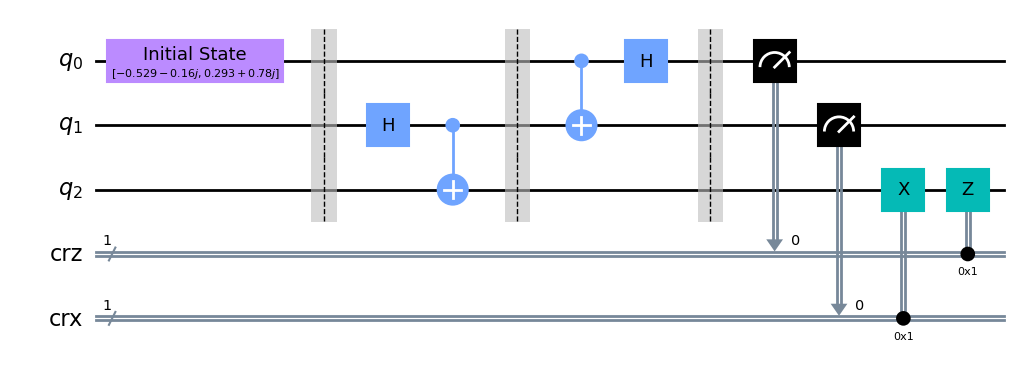

In [129]:
## SETUP
qr = QuantumRegister(3, name="q")   # Protocol uses 3 qubits
crz = ClassicalRegister(1, name="crz") # and 2 classical registers
crx = ClassicalRegister(1, name="crx")
qc = QuantumCircuit(qr, crz, crx)

## STEP 0
# First, let's initialize Alice's q0

init_gate = Initialize(psi)
init_gate.label = "Initial State"

qc.append(init_gate, [0])
qc.barrier()

## STEP 1
# Now begins the teleportation protocol
create_bell_pair(qc, 1, 2)
qc.barrier()

## STEP 2
# Send q1 to Alice and q2 to Bob
alice_gates(qc, 0, 1)

## STEP 3
# Alice then sends her classical bits to Bob
measure_and_send(qc, 0, 1)

## STEP 4
# Bob decodes qubits
bob_gates(qc, 2, crz, crx)

# Display the circuit
qc.draw('mpl')

Now we observe (but not measure!) the state of the qubits we have after the run: 

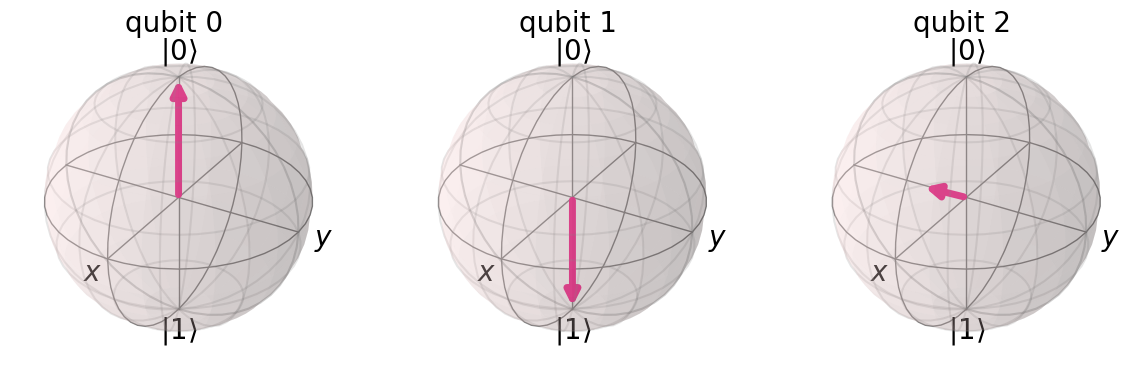

In [130]:
sim = Aer.get_backend('aer_simulator')
qc.save_statevector()
out_vector = sim.run(qc).result().get_statevector()
plot_bloch_multivector(out_vector)

We plot the initial state again and we see that qubit 2 is exactly in the same state our initial state $|\psi\rangle$ and thus we have succesfully teleported a qubit!

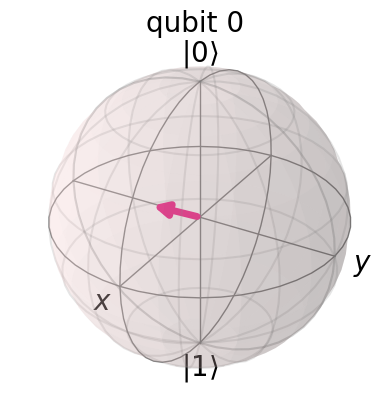

In [134]:
plot_bloch_multivector(psi)

Feel free to rerun this circuit multiple times and tweak around to see what changes. A fun exercise would be to think about how one can empirically check if we have teleported a qubit succesfully since in the above example we could 'see' the qubit however in an experiment that is not possible. The only information we have are the observed statistics.